<p style="text-align: center;font-size: 40pt">Point cloud processing</p>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
from IPython.display import HTML

%run ./scripts/helper_func.py
path = "{0}/lessons/transformations_2d/scripts/helper_func.py".format(get_root_path())
%run $path
path = "{0}/common/scripts/style.py".format(get_root_path())
%run $path

Hidden custom latex commands here $ \curvearrowright$

----
[comment]: <> (General commands)
$\DeclareMathOperator*{\argmin}{arg\,min}$
$\DeclareMathOperator{\error}{error}$
$\DeclareMathOperator*{\match}{match}$
$\DeclareMathOperator{\distance}{d}$
$\DeclareMathOperator{\outlier}{outlier}$
$\DeclareMathOperator{\weight}{w}$
$\DeclareMathOperator{\datafilter}{datafilter}$
$\newcommand{\mat}[1]{\mathbf{#1}}$
$\newcommand{\point}[2][]{{}^{#1}\mathbf{#2}}$
$\newcommand{\frame}[1]{\mathcal{#1}}$
$\newcommand{\shape}[2][]{{}^{#1}\mathcal{#2}}$
$\newcommand{\matches}[1]{\mathcal{#1}}$
$\newcommand{\transformation}[3][T]{{}_{#2}^{#3}\mat{#1}}$
$\newcommand{\weights}[1]{\mathcal{#1}}$
----

# Introduction
The different types of <tt>data filters</tt> try to augment the distinctiveness of the inputs usually by reducing the number of features and by augmenting the dimension of either the features or the descriptors.
For example, a black and white image has a uniform distribution of features (i.e., a grid of pixels) and one dimension descriptor (i.e., the light intensity) associated to each feature. 
After some <tt>data filters</tt> are applied, only few points in the image will be kept as features and the descriptors will be increased with information from neighboring pixels, for example to 64 dimensions when using Scale Invariant Feature Transform (SIFT) descriptors [[Lowe, 2004]](https://link.springer.com/article/10.1023%2FB%3AVISI.0000029664.99615.94).
In the case of a point cloud, it might be necessary to extract surface normal vectors (*feature enhancement*), while uniformizing the density of points (*features reduction*).
This can also be viewed as *lossy data compression*.

# Feature Enhancement
When only geometric information is available, there are still ways to extract some level of distinctness by using differential geometry.
Those methods introduced in the [lesson on differencial geometry](../uncertainty/3-lesson_diff_geo.ipynb).
As remainder of what those geometric primitives, a graphical representation of them is presented again in [Figure 2.1](#approximation1D) and in [Figure 2.2](#approximation2D).

<p id="approximation1D" style="text-align: center;">
    <img src="images/primitive1D.jpg" width="70%"/> <br/>
    <b>Figure 2.1:</b> Representations of a complex shape approximated as a 1D manifold.
    Representations (in dark blue) of a complex shape $\shape{S}$ (in light gray) approximated as a 1D manifold.
    <em>Left</em>: no derivative (point).
    <em>Middle</em>: first derivative (line).
    <em>Right</em>: second derivative (curve).
</p>

<p id="approximation2D" style="text-align: center;">
    <img src="images/primitive2D.jpg" width="70%"/> <br/>
    <b>Figure 2.2:</b> Representations of a complex shape approximated as a 1D manifold.
    Representations (in dark blue) of a complex shape $\shape{S}$ (in light gray) approximated as a 2D manifold.
    <em>Left</em>: no derivative (point).
    <em>Middle</em>: first derivative (plane).
    <em>Right</em>: second derivative (quadric).
</p>


## Sensitivity to transformation functions
The shape representations are affected differently by transformation functions.
At a more generic level, transformation functions affect geometric quantities.
Examples of quantities are: coordinate, orientation, length, angle, and length ratio.
Those geometric quantities with examples of associated primitives are recalled in [Table 2.3](#transformationQuanties).
As examples of lengths, we used $\kappa$, which is the inverse of a radius, and the eigenvalues $\lambda$, which define a scale over a vector.
Having geometric parameters invariant to as many transformations as possible helps the matching function during registration because the association will be less sensitive to large initial alignment error.
We already cover the effect of transformation functions on geometric quantities in the [lesson Transformation functions in 2D](../transformations_2d/2-lesson_transformation.ipynb), but we recall them in [Table 2.4](#influenceFunc) as a remainder.

<p id="transformationQuanties" style="text-align: center;margin-left: 5%;margin-right: 5%;">
    <b>Table 2.3:</b> Examples of geometric quantities susceptible to be affected by a transformation function.
    Legend: a point $\point{p}$, a normal vector $\mat{n}$, a tangent vector $\mat{t}$, a curvature $\kappa$, and an eigenvalue $\lambda$.
</p>

|  *Quantity*  |    &nbsp; *Single Entity* &nbsp;    |     *Relationship in a Set*    |
|:------------:|:-----------------------------------:|:------------------------------:|
|  Coordinate  |             $\point{p}$             |                -               |
|  Orientation | $\mat{n}, \mat{t}_\mathrm{min}, \mat{t}_\mathrm{max}$ |     -        |
|    Length    |          $\kappa, \lambda$          | $||\point{p}_a - \point{p}_b||$|
|     Angle    |             -           | $\text{arccos}(\mat{n}_a \cdot \mat{n}_b)$ |
| Length Ratio |                  -                  |      $\kappa_a / \kappa_b$     |

<p id="influenceFunc" style="text-align: center;margin-left: 5%;margin-right: 5%;">
    <b>Table 2.4:</b> Influence of a transformation function on quantities defining a geometric primitive.
    Influence of a transformation function on quantities defining a geometric primitive.
    Cells marked with a "X" mean that the transformation affects the values of the entity.
</p>

|       *Function*       | *Coordinate* | *Length* | *Orientation* | *Angle* | *Length Ratio* |
|:----------------------:|:------------:|:--------:|:-------------:|:-------:|:--------------:|
|       Translation      |       X      |     -    |       -       |    -    |        -       |
|     Uniform Scaling    |       X      |     X    |       -       |    -    |        -       |
|        Rotation        |       X      |     -    |       X       |    -    |        -       |
|   Nonuniform Scaling   |       X      |     X    |       X       |    X    |        -       |
|          Shear         |       X      |     X    |       X       |    X    |        X       |
|  Orthogonal Projection |       X      |     X    |       X       |    X    |        X       |
| Perspective Projection |       X      |     X    |       X       |    X    |        X       |

Most of the time, point cloud features come without external descriptors (i.e., as opposed to an image containing photometric information), so the proximity of other features is used to extend the shape approximation to support further derivatives. 
Surface orientations, or line orientations in 2D, are mainly used in literature [\[Pulli, 1999](https://ieeexplore.ieee.org/document/805346), [Censi,
2008](https://ieeexplore.ieee.org/document/4543181), [Bosse and Zlot, 2009b](https://ieeexplore.ieee.org/document/5152851), [Jost and Hugli, 2002](https://ieeexplore.ieee.org/document/1024114), [Schutz et al., 1998](https://ieeexplore.ieee.org/document/711852),
[Jost and Hügli, 2002](https://link.springer.com/chapter/10.1007/3-540-45783-6_12), [Segal et al., 2009\]](http://www.roboticsproceedings.org/rss05/p21.html). 
Line orientations are also used in image registration where the environment presents very few salient points when considering only intensity variation [[Stewart et al.,
2003]](https://ieeexplore.ieee.org/document/1242341). 
Work based on surface normal vector distributions of surrounding points are also used by [Magnusson et al. [2009]](https://ieeexplore.ieee.org/document/5152538) and [Fairfield and Wettergreen [2009]](https://ieeexplore.ieee.org/document/5152688).

# Descriptor Enhancement
A comparison of descriptors extracted from 2D point clouds can be found in [[Bosse and Zlot, 2009a]](https://www.sciencedirect.com/science/article/abs/pii/S0921889009000992).
It is proposed that moment grid is better than 2D shape context, Gestalt, Hough transform peaks, orientation and projection histograms, and normal orientation histogram grid. 
Extension to the 2D shape context can be found in [[Tsai et al., 2010]](https://ieeexplore.ieee.org/document/5223602). 
Another study for 3D point clouds also concludes that moment grid is better than 3D shape context, spin image, shell image and local covariance [[Bosse and Zlot, 2009b]](https://ieeexplore.ieee.org/document/5152851).

Usually, Iterative Closest Point (ICP) is done using only geometric features, but some works also present results using the intensity remission from an Hokuyo [[Yoshitaka et al., 2006]](https://ieeexplore.ieee.org/document/4153430) and from specialized system using three different wavelengths [[Godin et al., 1994]](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/2350/1/Three-dimensional-registration-using-range-and-intensity-information/10.1117/12.189139.short). 
Laser range finders are also combined with cameras to add color information to measured points [\[Schutz et al., 1998](https://ieeexplore.ieee.org/document/711852), [Druon et al., 2006\]](https://ieeexplore.ieee.org/document/4097937).
When other sensors are used to provide descriptors, calibration is required.
Interestingly, calibration is also an optimization problem that relies on registration solutions.
Terrestrial survey scanners often have a calibrated camera associating color to 3D points, similar to RGB-D cameras.
With the larger availability of photometric information, descriptors developed by the computer vision community can be used.
In [[Tuytelaars and Mikolajczyk, 2008]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.83.7050&rep=rep1&type=pdf), characteristics of descriptive features are listed as *rotation*, *scale*, and *affine invariance*.
Evaluation criteria are listed as *repeatability*, *distinctiveness*, *locality*, *quantity*, *accuracy*, and *efficiency*. 
In image registration, the list of most common tools for extracting descriptors are: Harris, Hessian, SUSAN, Harris-Laplace, Hessian-Laplace, DoG (SIFT), SURF, Harris-Affine, Hessian-Affine, Salient Regions, Edge-based, MSER, Intensity-based and Superpixel [[Tuytelaars and Mikolajczyk, 2008]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.83.7050&rep=rep1&type=pdf).
It is interesting to note that descriptors based on photometric information rely on passive illumination to ensure invariance.
This assumption of illumination sources remaining static, which is mostly true for indoor lights, needs to be treated carefully for outdoor illumination, where the sun moves and clouds can shade light.
Intensity measurements from lidars are even more sensitive to transformation functions because the illumination source follows the sensor position.

# Feature Reduction
In applications using point clouds, features are sparse but not uniformly distributed.
An example of this nonuniform distribution is depicted in [Figure 2.3](#coverage3D).
Nevertheless, the fact that sensors can provide a huge number of readings on a short period of time creates a bottleneck in term of computation power for the association as explained later.
Several techniques are used to reduce the number of features: random sampling [\[Jost and Hugli, 2002](https://ieeexplore.ieee.org/document/1024114), [Pan et al., 2010\]](https://ieeexplore.ieee.org/document/5476132), uniform grid [\[Magnusson et al., 2009](https://ieeexplore.ieee.org/document/5152538), [Bosse and Zlot, 2009b\]](https://ieeexplore.ieee.org/document/5152851), grid projection [[Pan et al., 2010]](https://ieeexplore.ieee.org/document/5476132), octree [\[Fairfield and Wettergreen, 2009](https://ieeexplore.ieee.org/document/5152688), [Wurm et al., 2010\]](http://www2.informatik.uni-freiburg.de/~stachnis/pdf/wurm10icraws.pdf), and bounding box [\[Stewart et al., 2003](https://ieeexplore.ieee.org/document/1242341), [Tsai et al., 2010\]](https://ieeexplore.ieee.org/document/5223602). 
All these techniques reduce the number of features without considering their distinctiveness. 


<p id="coverage3D" style="text-align: center;">
    <img src="images/3DSensorConfigPitchNoOffsetAndCoverage.jpg" width="100%"/> <br/>
    <b>Figure 2.3:</b> The impact of rotating a 2D lidar (on the right) along an axis of rotation on the y-axis.
    We see in the simulated cylinder that the density of points if far from uniform in the Euclidean space.
</p>

Having the distinctiveness criteria in mind, [Bosse and Zlot [2009a]](https://www.sciencedirect.com/science/article/abs/pii/S0921889009000992) present results showing that keeping a representative point per curvature cluster is better than segment centroids and mean-shift for 2D point clouds.
Also, [Gelfand et al. [2003]](https://ieeexplore.ieee.org/document/1240258) propose a sampling method selecting points leading to a better geometric stability of the minimization. 
Relying on non-geometric information, [Druon et al. [2006]](https://ieeexplore.ieee.org/document/4097937) use seven clusters based on hue values and select only one cluster carrying the most information for registration. 
The same type of solution was previously presented before by [Godin et al. [1994]](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/2350/1/Three-dimensional-registration-using-range-and-intensity-information/10.1117/12.189139.short), who clustered point based on laser intensity values.

It is also possible to find more application-specific methods in the literature. 
For example, the tip of the nose, inner corners of the eyes, and nose corners are directly extracted for face detection [[Pan et al., 2010]](https://ieeexplore.ieee.org/document/5476132). 
In medical imagery, blood vessel crossings are also used to reduce features. 
Moreover, the main orientation of the blood vessel crossings and its number of branching is used to construct descriptors [[Stewart et al., 2003]](https://ieeexplore.ieee.org/document/1242341).
The complete point cloud can also be reduced to its first and second statistical moments [[Liu, 2010]](https://ieeexplore.ieee.org/document/5291420) or with orientation and projection histograms [[Bosse and Zlot, 2008]](https://journals.sagepub.com/doi/10.1177/0278364908091366).

# Sensor Noise
Sensor noise is also taken into account at this stage of the process.
Models representing noises are intended to evaluate the uncertainty of a measured point based on the limitations of the sensor used.
They may try to identify if a point is a measurement artifact or how accurately the position is measured.
To cope with stereo reconstruction noise, [Diebel et al. [2004]](https://ieeexplore.ieee.org/document/1389948) remove points with distance and surface angle to neighbors larger than two times the median of all distances and surface angles within the point cloud. 
When using laser's remission intensity, which is not invariant to distance and angle, [Yoshitaka et al. [2006]](https://ieeexplore.ieee.org/document/4153430) propose to keep points only close to the laser to reduce the impact of distance on the intensity value. 
For color images, points with low saturation value tend to be gray and are removed before applying clustering technique based on hue [[Druon et al., 2006]](https://ieeexplore.ieee.org/document/4097937). 
Points on boundaries of the sensor reading can also be removed to avoid misleading interpretation of neighbor points [[Armesto et al., 2010]](https://ieeexplore.ieee.org/document/5509371).
When an error model is available, it is also possible to add noise information based on measurement distance, incidence angle, and reflectivity to name few.
Examples of noise models on distance reading are investigated for Sick LMS-151, Hokuyo URG and UTM in [[Pomerleau et al., 2012a]](https://ieeexplore.ieee.org/document/6473358).

## Example 1
The simplest of the filters is a random subsampling in order to decimate the point cloud:

$$
    \shape{P'} = \datafilter(\shape{P}) = \left\{\point{p} \in \shape{P}: \eta(\point{p})<\theta\right\}
$$

where $\eta\in[0,1)$ is a uniform-distributed random value and $\theta\in[0,1]$ a fixed threshold, corresponding to the fraction of points to keep.
The following code cell gives an example of such subsampling technique demonstrating that, even when removing a high percentage of points, the global shape of the point cloud is preserved.  

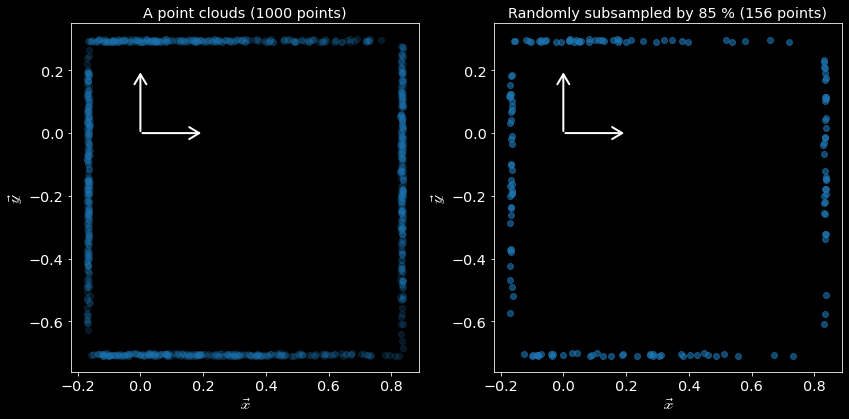

In [19]:
# Generate two point clouds
P = build_room([1.2, 2.], [2.2, 1.5], angle=-0, nb_pts=1000)

# keep some percentage of the points
nb_pts = P.shape[1]
theta = 0.85
prob = np.random.uniform(size=nb_pts)
mask = (prob > theta)
P_prime = P[:, mask]

# -----------------------
# plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax=axs[0]
draw_point_clouds(ax, P=P, alpha=0.2)
ax.set_title("A point clouds (%i points)" % nb_pts);

ax=axs[1]
draw_point_clouds(ax, P=P_prime, alpha=0.6)
ax.set_title("Randomly subsampled by %.0f %% (%i points)" % ((theta*100.), P_prime.shape[1]));

fig.tight_layout()

## Example 2
A second example is the computation of normal vectors in a point cloud:

$$
    \shape{P'} = \datafilter(\shape{P}) = \left\{
        \left[\begin{array}{c}\point{p}\\n\end{array}\right]:
        \forall\point{p} \in \shape{P}, n=\text{normal}(\point{p})
    \right\}
$$

where $\text{normal}(\point{p})$ is the normal vector inferred around point $\point{p}$.
This computation was given as a code example in the [lesson on differential geometry](../uncertainty/3-lesson_diff_geo.ipynb#Extract-surface-tangents).
The example was about computing tangent vectors.
If you want to extract vector normal to a line, you need to take the eigenvector associated with the lowest eigenvalue instead of the highest eigenvalue.

## Other examples

A large list of more than 20 preprocessing filters is available over [here with multiple images](https://github.com/ethz-asl/libpointmatcher/blob/master/doc/DataFilters.md).

# Conclusion
TODO